In [1]:
# Import packages
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import setuptools

In [ ]:
# Import bing-image-down Loader
from bing_image_downloader import downloader
# DownLoad images
downloader.download("pizza",limit=500, output_dir="photos")
downloader.download("pasta", limit=500, output_dir="photos")

In [2]:
#Filepaths for the pizza and pasta images
filepath_pizza ="./photos/pizza/*"
filepath_pasta = "./photos/pasta/*"

# Collect all the image filepaths into Lists
pizza_files = [file for file in glob.iglob(filepath_pizza)]
pasta_files = [file for file in glob.iglob(filepath_pasta)]

# Construct pandas dataframe with all the image filenames and labels
df_photos = (
    pd.DataFrame({"filepath": pizza_files, "label": np.zeros(len(pizza_files))})
    ._append(
        pd.DataFrame({"filepath": pasta_files, "label": np.ones(len(pasta_files))})
    )
)


In [3]:
# Import train_test_split
from sklearn.model_selection import train_test_split
# Split our dataset
df_train, df_test = train_test_split(df_photos, test_size=0.2, random_state=1)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)


In [4]:
# Wrapper function to load and process images
def process_image(filepath):
    return np.asarray(Image.open(filepath).resize((128, 128)).convert("L")) / 255.0

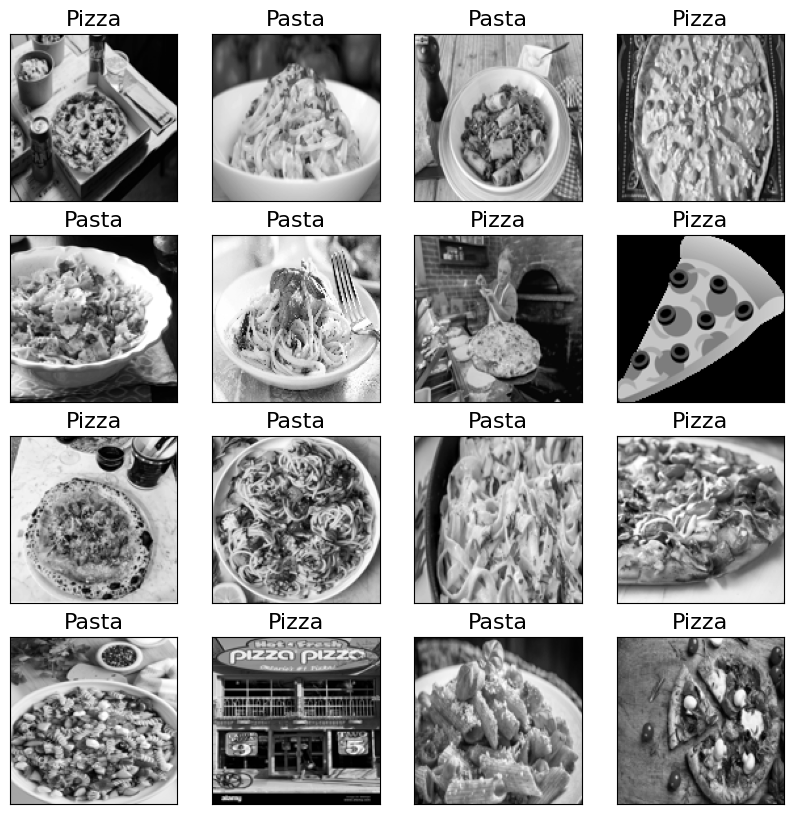

In [5]:
# Load image
img = process_image(pizza_files[0])
# Plot image
# Plot 16 images from our training set with labels
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img = process_image(df_train["filepath"].iloc[i])
    plt.imshow(img, cmap="gray")
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    if df_train["label"].iloc[i] == 0:
        plt.title("Pizza", size=16)
    else:
        plt.title("Pasta", size=16)
plt.show()

In [6]:
# Create array of training images
train_images = np.empty([df_train.shape[0], 128, 128])
for index, row in df_train.iterrows():
    img = process_image(row.filepath)
    train_images[index] = img
# Create array of test images
test_images = np.empty([df_test.shape[0], 128, 128])
for index, row in df_test.iterrows():
    img = process_image(row.filepath)
    test_images[index] = img



/opt/homebrew/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
# Create array of training labels
train_labels = df_train["label"].to_numpy()
# Create array of test labels
test_labels = df_test["label"].to_numpy()

In [8]:
# Import keras
import tensorflow.keras as keras

In [9]:
# Create our model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(2, activation="softmax")
])

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    14,745,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,765,186 (56.32 MB)

 Trainable params: 14,765,186 (56.32 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Set the learning rate
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9
)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile our model
model.compile(optimizer=opt,           loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [12]:
# Import ImageDataGenerator for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up data augmentation
data_gen = ImageDataGenerator(
    rotation_range=15,         # Randomly rotate images by 15 degrees
    width_shift_range=0.1,     # Randomly shift images horizontally
    height_shift_range=0.1,    # Randomly shift images vertically
    zoom_range=0.2,            # Randomly zoom images
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest',       # Fill pixels when applying transformations
    validation_split=0.2       # Use 20% of training data for validation
)

# Apply data augmentation to the training dataset
train_gen = data_gen.flow(
    train_images[..., np.newaxis],  # Add channel dimension
    train_labels,
    batch_size=32,
    subset='training',
    shuffle=True
)

val_gen = data_gen.flow(
    train_images[..., np.newaxis],  # Add channel dimension
    train_labels,
    batch_size=32,
    subset='validation'
)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50


/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/homebrew/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.5192 - loss: 0.7480 - val_accuracy: 0.4938 - val_loss: 0.6901
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.5661 - loss: 0.6657 - val_accuracy: 0.6562 - val_loss: 0.6558
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.5777 - loss: 0.6667 - val_accuracy: 0.6687 - val_loss: 0.6464
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.5807 - loss: 0.6556 - val_accuracy: 0.6438 - val_loss: 0.6389
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.6632 - loss: 0.6242 - val_accuracy: 0.6687 - val_loss: 0.6283
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.6579 - loss: 0.6221 - val_accuracy: 0.6562 - val_loss: 0.6247
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.6220 - loss: 0.6445 - val_accuracy: 0.6375 - val_loss: 0.6251
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.6564 - loss: 0.6149 - val_accuracy: 0.6562 - val_

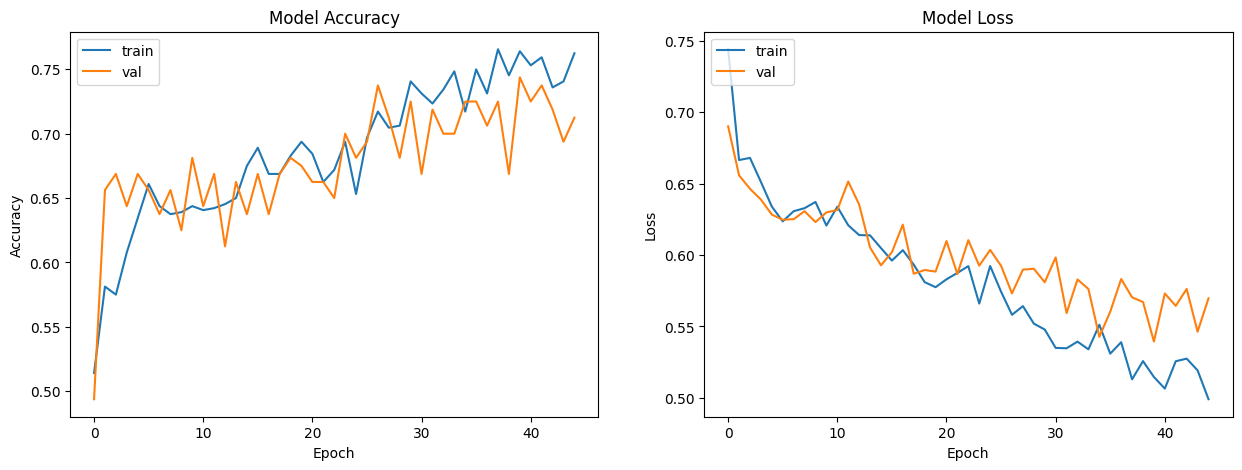

In [14]:
# Plot accuracy
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['train', 'val'], loc='upper left')
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
# Evaluate CNN on the test set
cnn_test_loss, cnn_test_accuracy = model.evaluate(test_images[..., np.newaxis], test_labels, verbose=2)
print(f"CNN Test Accuracy: {cnn_test_accuracy * 100:.2f}%")
print(f"CNN Test Loss: {cnn_test_loss:.4f}")

7/7 - 0s - 29ms/step - accuracy: 0.7300 - loss: 0.5400
CNN Test Accuracy: 73.00%
CNN Test Loss: 0.5400


In [16]:
# Function to return prediction and probability
def model_prediction(model, img):
    predictions = model.predict(np.array([img]))
    
    if predictions[0][0] > predictions[0][1]:
        return f"Pizza: {round(100*predictions[0][0], 2)}%"
    else:
        return f"Pasta: {round(100*predictions[0][1], 2)}%"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


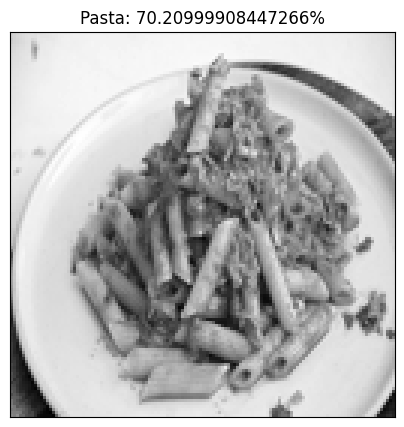

In [17]:
# Load image of cacio e pepe
cacio_e_pepe = process_image("./p.jpg")
# Plot image along with prediction
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.imshow(cacio_e_pepe, cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(model_prediction(model, cacio_e_pepe))
plt.show()


In [18]:
# Flatten the images for MLP input
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

In [19]:
# Import necessary modules from TensorFlow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [20]:
# Build the MLP model
mlp_model = Sequential([
    Dense(1024, activation='relu', input_shape=(128 * 128,)),  # First hidden layer with 512 units
    Dropout(0.3),                                            # Dropout to prevent overfitting
    Dense(512, activation='relu'),                           # Second hidden layer with 256 units
    Dropout(0.3),                                            # Dropout
    Dense(256, activation='relu'),                           # Third hidden layer with 128 units
    Dropout(0.3),                                            # Dropout
    Dense(2, activation='softmax')                           # Output layer for 2 classes
])

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam


# Define a learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9  # Reduce learning rate by 10% after 10 epochs

# Compile the model
mlp_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks: EarlyStopping and LearningRateScheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_schedule_callback = LearningRateScheduler(lr_scheduler)

In [22]:
# Model summary
mlp_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 1024)           │    16,778,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,434,882 (66.51 MB)

 Trainable params: 17,434,882 (66.51 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Train the MLP model
mlp_history = mlp_model.fit(
    train_images_flat,
    train_labels,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping,lr_schedule_callback]
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5436 - loss: 6.6931 - val_accuracy: 0.5000 - val_loss: 0.7384 - learning_rate: 0.0010
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5475 - loss: 2.9890 - val_accuracy: 0.5500 - val_loss: 0.7507 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4920 - loss: 1.5293 - val_accuracy: 0.5000 - val_loss: 0.7317 - learning_rate: 0.0010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5705 - loss: 1.0042 - val_accuracy: 0.5000 - val_loss: 0.7236 - learning_rate: 0.0010
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5419 - loss: 0.7962 - val_accuracy: 0.5000 - val_loss: 0.6939 - learning_rate: 0.0010
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5657 - loss: 0.7378 - val_accuracy: 0.6250 - val_loss: 0.6671 - learning_rate: 0.0010
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5959 - loss: 0.6644 - val_acc

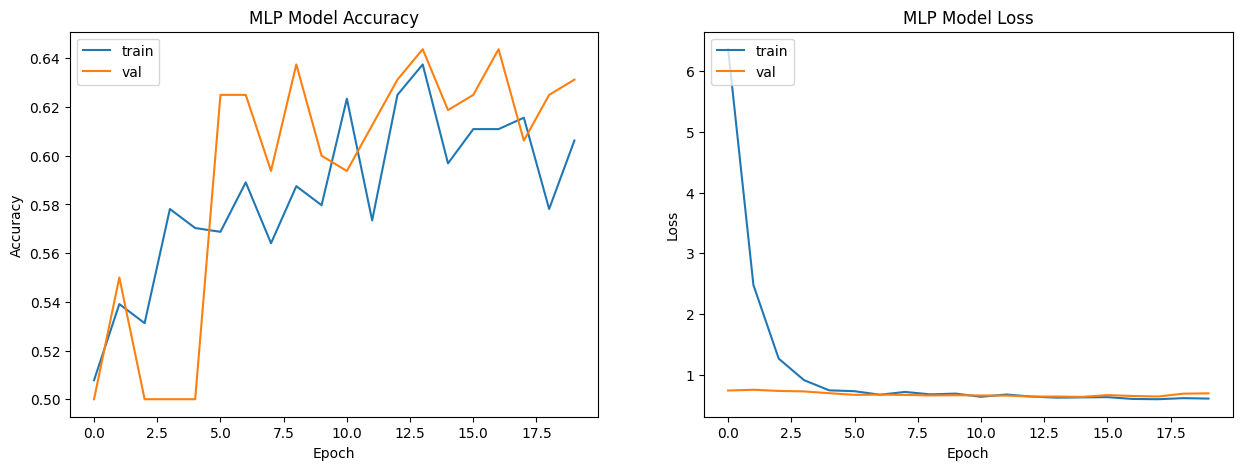

In [24]:
# Plot accuracy and loss
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(mlp_history.history['accuracy'])
ax1.plot(mlp_history.history['val_accuracy'])
ax1.set_title('MLP Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['train', 'val'], loc='upper left')
ax2.plot(mlp_history.history['loss'])
ax2.plot(mlp_history.history['val_loss'])
ax2.set_title('MLP Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
# Evaluate MLP on the test set
mlp_test_loss, mlp_test_accuracy = mlp_model.evaluate(test_images_flat, test_labels, verbose=2)
print(f"MLP Test Accuracy: {mlp_test_accuracy * 100:.2f}%")
print(f"MLP Test Loss: {mlp_test_loss:.4f}")

7/7 - 0s - 14ms/step - accuracy: 0.6500 - loss: 0.6221
MLP Test Accuracy: 65.00%
MLP Test Loss: 0.6221


In [26]:
# Predict function for MLP
def mlp_model_prediction(model, img):
    img_flat = img.flatten().reshape(1, -1)  # Flatten the image
    prediction = model.predict(img_flat)
    if prediction[0][0] > prediction[0][1]:
        return f"Pizza: {round(100 * prediction[0][0], 2)}%"
    else:
        return f"Pasta: {round(100 * prediction[0][1], 2)}%"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


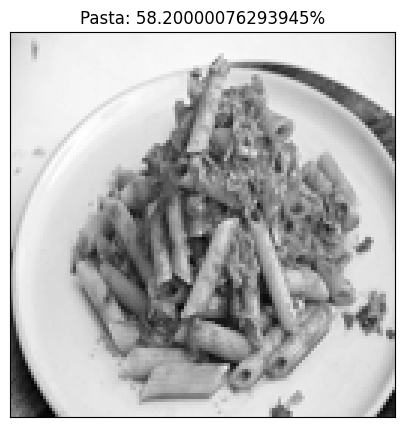

In [27]:
# Test with an example image
cacio_e_pepe1 = process_image("./p.jpg")
cacio_e_pepe_flat = cacio_e_pepe1.flatten()
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.imshow(cacio_e_pepe1, cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(mlp_model_prediction(mlp_model, cacio_e_pepe_flat))
plt.show()

In [28]:
# Import necessary libraries
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [29]:
# Flatten the images for SVM input
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

# Build an SVM pipeline with standardization
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),       # Normalize the features
    ('svm', SVC(kernel='linear', probability=True))  # SVM with linear kernel
])

In [30]:
from sklearn.model_selection import GridSearchCV

# Grid Search for hyperparameter tuning
param_grid = {
    'svm__C': [0.1, 1, 10, 100],          # Regularization parameter
    'svm__kernel': ['linear', 'rbf'],     # Linear or RBF kernel
    'svm__gamma': ['scale', 'auto']       # Kernel coefficient for 'rbf'
}

grid_search = GridSearchCV(svm_pipeline, param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(train_images_flat, train_labels)

# Best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate the best model on the test set
best_svm = grid_search.best_estimator_
test_predictions = best_svm.predict(test_images_flat)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   5.9s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   5.9s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   5.8s
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=   7.3s
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=   7.2s
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=   7.1s
[CV] END ....svm__C=0.1, svm__gamma=auto, svm__kernel=linear; total time=   5.9s
[CV] END ....svm__C=0.1, svm__gamma=auto, svm__kernel=linear; total time=   5.9s
[CV] END ....svm__C=0.1, svm__gamma=auto, svm__kernel=linear; total time=   6.3s
[CV] END .......svm__C=0.1, svm__gamma=auto, svm__kernel=rbf; total time=   7.3s
[CV] END .......svm__C=0.1, svm__gamma=auto, svm__kernel=rbf; total time=   7.3s
[CV] END .......svm__C=0.1, svm__gamma=auto, svm

In [31]:
# Evaluate the model
print("SVM Classification Report:")
print(classification_report(test_labels, test_predictions))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(cm)


SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.67      0.70        96
         1.0       0.72      0.79      0.75       104

    accuracy                           0.73       200
   macro avg       0.73      0.73      0.73       200
weighted avg       0.73      0.73      0.73       200

Confusion Matrix:
[[64 32]
 [22 82]]


In [32]:
# Test accuracy
svm_test_accuracy = best_svm.score(test_images_flat, test_labels)  # Use the best estimator
print(f"SVM Test Accuracy: {svm_test_accuracy * 100:.2f}%")

SVM Test Accuracy: 73.00%


svm_probabilities: [[0.32027332 0.67972668]]
svm_probabilities shape: (1, 2)
svm_prediction: [1]
svm_prediction shape: (1,)


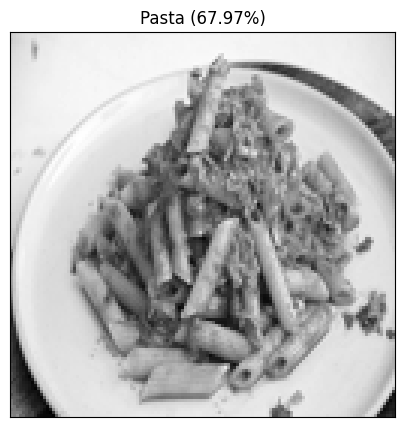

In [33]:
# Test with an example image
cacio_e_pepe2 = process_image("./p.jpg")  # Preprocess the image
cacio_e_pepe_flat2 = cacio_e_pepe2.flatten().reshape(1, -1)  # Flatten and reshape to 2D

# Standardize the flattened image using the scaler in the fitted pipeline
cacio_e_pepe_scaled = best_svm.named_steps['scaler'].transform(cacio_e_pepe_flat2)

# Predict using the fitted SVM model
svm_prediction = best_svm.named_steps['svm'].predict(cacio_e_pepe_scaled).astype(int)  # Convert prediction to integer
svm_probabilities = best_svm.named_steps['svm'].predict_proba(cacio_e_pepe_scaled)

# Debugging output
print("svm_probabilities:", svm_probabilities)
print("svm_probabilities shape:", svm_probabilities.shape)
print("svm_prediction:", svm_prediction)
print("svm_prediction shape:", svm_prediction.shape)

# Determine class and confidence
class_names = {0: "Pizza", 1: "Pasta"}  # Class label mapping
predicted_label = class_names[svm_prediction[0]]
confidence = svm_probabilities[0, svm_prediction[0]] * 100  # Fixed indexing

# Plot the image with prediction
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.imshow(cacio_e_pepe2, cmap="gray")  # Display the image
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f"{predicted_label} ({confidence:.2f}%)")
plt.show()

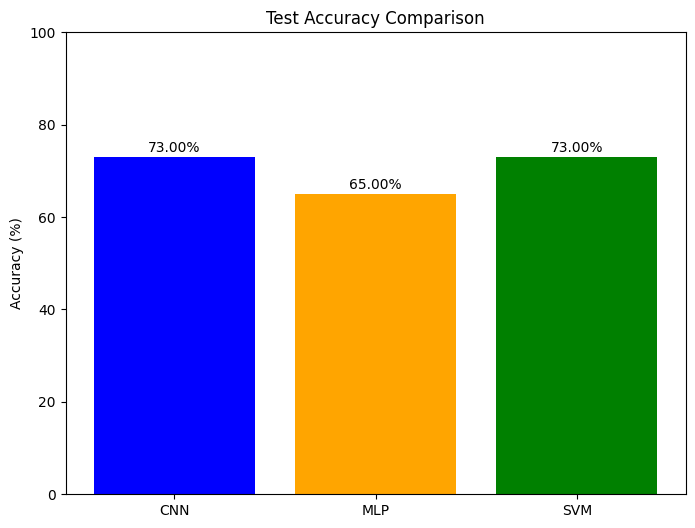

In [34]:
# Collect the test accuracies
models = ['CNN', 'MLP', 'SVM']
accuracies = [cnn_test_accuracy * 100, mlp_test_accuracy * 100, svm_test_accuracy * 100]

# Bar plot for test accuracy comparison
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'orange', 'green'])
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center')
plt.show()

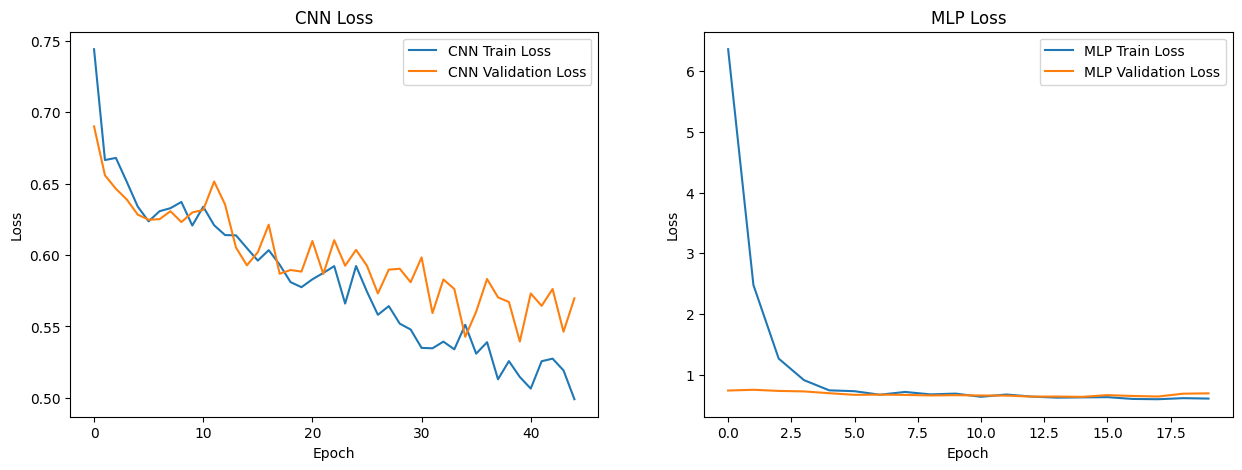

CNN Test Loss: 0.5400
MLP Test Loss: 0.6221


In [35]:
# Compare training and validation loss
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# CNN Loss
ax[0].plot(history.history['loss'], label='CNN Train Loss')
ax[0].plot(history.history['val_loss'], label='CNN Validation Loss')
ax[0].set_title('CNN Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# MLP Loss
ax[1].plot(mlp_history.history['loss'], label='MLP Train Loss')
ax[1].plot(mlp_history.history['val_loss'], label='MLP Validation Loss')
ax[1].set_title('MLP Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()

# Print final test losses
print(f"CNN Test Loss: {cnn_test_loss:.4f}")
print(f"MLP Test Loss: {mlp_test_loss:.4f}")